# Model Performance Evaluation
Work for Masters Thesis

Stanley Fujimoto

In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import math
import numpy as np

%matplotlib inline

/Users/masaki/software/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
available_features_str = "aliscore,length,num_seqs,num_gaps,num_amino_acids,range,amino_acid_charged,amino_acid_uncharged,amino_acid_special,amino_acid_hydrophobic"
available_features = available_features_str.split( ',' )

## Data Prep

In [3]:
# load data
data = pickle.load( open( "../data/featurized_data.pickle", "rb" ) )

### split the data

In [4]:
#x_train, x_test, y_train, y_test = train_test_split( features, labels, test_size = 0.2 )
sdata = shuffle( data )
train, test = train_test_split( sdata, test_size = 0.2 )
x_test = test[ available_features ]
y_test = test[ "class" ]

In [5]:
# check on test set
print x_test.head()
print y_test.head()

      aliscore  length  num_seqs  num_gaps  num_amino_acids  range  \
3194      1032    1334        91     88410            32984     60   
2221      1762    2193        86    124849            63749     60   
8543      4671    4672       107    388181           111723     60   
1          182     331        76     12020            13136     59   
537        527    1008        92     39459            53277     58   

      amino_acid_charged  amino_acid_uncharged  amino_acid_special  \
3194           31.579309             33.017030           26.921942   
2221           70.755965             65.176126           28.987778   
8543           75.631597             67.109407           44.567159   
1               5.273086              5.197975            3.442357   
537            29.405551             29.108041           13.203939   

      amino_acid_hydrophobic  
3194               32.306280  
2221               82.162397  
8543              116.253934  
1                   8.736644  
537

## Model Testing

#### Model testing parameters

In [26]:
bootstrap_percentages_str = "1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100"
bootstrap_percentages_str = "10,20,30,40,50,60,70,80,90,100"
bootstrap_percentages = map( float, bootstrap_percentages_str.split( ',' ) )
replicates = 10

### SVM

In [ ]:
svm_data = sdata
svm_data[ available_features ] = scale( svm_data[ available_features ] )
svm_train, svm_test = train_test_split( svm_data, test_size = 0.2 )
svm_x_test = svm_test[ available_features ]
svm_y_test = svm_test[ "class" ]

In [ ]:
# svm, no bootstrap test.
perc = float( 3 )
num_instances = int( math.ceil( ( perc / 100 ) * len( train ) ) )
print num_instances

sub_train = svm_train.sample( num_instances, replace = True )
svm_x_train = sub_train[ available_features ]
svm_y_train = sub_train[ "class" ]

svc = SVC( kernel = "poly", verbose = True, cache_size = 2000 )
svc.fit( svm_x_train, svm_y_train )

In [ ]:
svc_preds = svc.predict( svm_x_train )
acc = accuracy_score( svc_preds, svm_y_train )
print acc

In [ ]:
svc_preds = svc.predict( svm_x_test )
acc = accuracy_score( svc_preds, svm_y_test )
print acc

#### Bootstrap analysis

In [24]:
svm_data = sdata
svm_data[ available_features ] = scale( svm_data[ available_features ] )
svm_train, svm_test = train_test_split( svm_data, test_size = 0.2 )
svm_x_test = svm_test[ available_features ]
svm_y_test = svm_test[ "class" ]
                                       
acc_train = []
acc_test = []
for perc in bootstrap_percentages:
    # resample data
    num_instances = int( math.ceil( len( train ) * ( perc / 100 ) ) )
    
    acc_perc_train = []
    acc_perc_test = []
    
    for rep in range( replicates ):
        sub_train = svm_train.sample( num_instances, replace = True )
        x_train = sub_train[ available_features ]
        y_train = sub_train[ "class" ]
        
        #print "\trep:", rep
        svc = SVC( kernel = "poly", cache_size = 4000 )
        svc.fit( x_train, y_train )
        
        # train dataset
        svc_preds = svc.predict( x_train )
        acc_perc_train.append( accuracy_score( svc_preds, y_train ) )
        
        # test dataset
        svc_preds = svc.predict( svm_x_test )
        acc_perc_test.append( accuracy_score( svc_preds, svm_y_test ) )
    
    print "perc:", perc, np.mean( acc_perc_train ), np.mean( acc_perc_test ), np.std( acc_perc_train ), np.std( acc_perc_test )
    acc_train.append( acc_perc_train )
    acc_test.append( acc_perc_test )
    
    #print acc_train

perc: 1.0
perc: 2.0
perc: 3.0
perc: 4.0
perc: 5.0
perc: 6.0
perc: 7.0
perc: 8.0
perc: 9.0
perc: 10.0
perc: 15.0
perc: 20.0
perc: 25.0
perc: 30.0
perc: 35.0
perc: 40.0
perc: 45.0
perc: 50.0
perc: 55.0
perc: 60.0
perc: 65.0
perc: 70.0
perc: 75.0
perc: 80.0
perc: 85.0
perc: 90.0
perc: 95.0
perc: 100.0


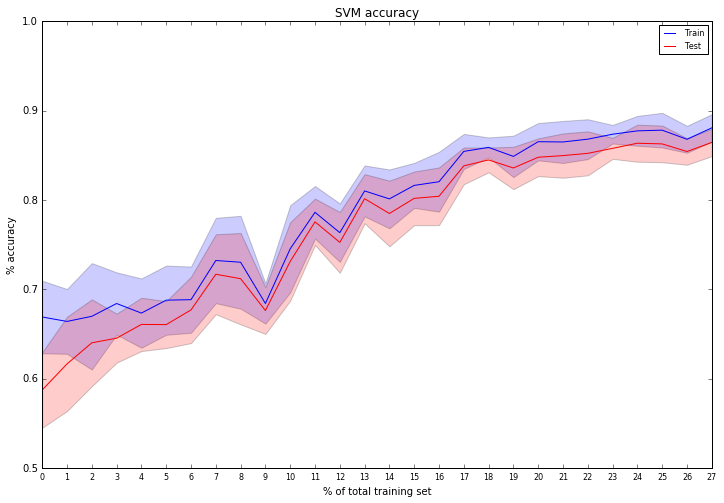

In [25]:
model = "SVM"

acc_train_ = np.asarray( acc_train )
acc_test_ = np.asarray( acc_test )

avgs_train = acc_train_.mean( axis = 1 )
errs_train = acc_train_.std( axis = 1 )

avgs_test = acc_test_.mean( axis = 1 )
errs_test = acc_test_.std( axis = 1 )

avgs = pd.DataFrame( [ avgs_train, avgs_test ] ).transpose()
avgs.columns = [ "Train", "Test" ]

errs = pd.DataFrame( [ errs_train, errs_test ] ).transpose()
errs.columns = [ "Train", "Test" ]

fig, ax = plt.subplots()
fig.set_size_inches( 12, 8, forward = True )
plt.title( model + " accuracy" )
plt.ylim( 0.5, 1.0 )
plt.xlabel( "% of total training set" )
plt.ylabel( "% accuracy" )
avgs.plot.line( ax = ax, color = [ 'b', 'r' ] )
plt.fill_between( avgs.index.values, avgs[ "Train" ] - errs[ "Train" ], avgs[ "Train" ] + errs[ "Train" ], facecolor = 'blue', alpha = 0.2 )
plt.fill_between( avgs.index.values, avgs[ "Test" ] - errs[ "Test" ], avgs[ "Test" ] + errs[ "Test" ], facecolor = 'red', alpha = 0.2 )
plt.xticks( avgs.index.values, map( str, avgs.index.values ), fontsize = 8 )
leg = plt.legend( fontsize = 8 )
plt.show()

### MLP

In [22]:
mlp_data = sdata
mlp_data[ available_features ] = scale( mlp_data[ available_features ] )
mlp_train, mlp_test = train_test_split( mlp_data, test_size = 0.2 )
mlp_x_test = mlp_test[ available_features ]
mlp_y_test = mlp_test[ "class" ]
                                       
acc_train = []
acc_test = []
for perc in bootstrap_percentages:
    # resample data
    num_instances = int( math.ceil( len( train ) * ( perc / 100 ) ) )
    
    acc_perc_train = []
    acc_perc_test = []
    
    for rep in range( replicates ):
        sub_train = mlp_train.sample( num_instances, replace = True )
        x_train = sub_train[ available_features ]
        y_train = sub_train[ "class" ]
        
        #print "\trep:", rep
        mlp = MLPClassifier()
        mlp.fit( x_train, y_train )
        
        # train dataset
        mlp_preds = mlp.predict( x_train )
        acc_perc_train.append( accuracy_score( mlp_preds, y_train ) )
        
        # test dataset
        mlp_preds = mlp.predict( mlp_x_test )
        acc_perc_test.append( accuracy_score( mlp_preds, mlp_y_test ) )
    
    print "perc:", perc, np.mean( acc_perc_train ), np.mean( acc_perc_test ), np.std( acc_perc_train ), np.std( acc_perc_test )
    acc_train.append( acc_perc_train )
    acc_test.append( acc_perc_test )
    
    #print acc_train

perc: 1.0


/Users/masaki/software/scikit-learn/sklearn/neural_network/multilayer_perceptron.py:560: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


perc: 2.0
perc: 3.0
perc: 4.0
perc: 5.0
perc: 6.0
perc: 7.0
perc: 8.0
perc: 9.0
perc: 10.0
perc: 15.0
perc: 20.0
perc: 25.0
perc: 30.0
perc: 35.0
perc: 40.0
perc: 45.0
perc: 50.0
perc: 55.0
perc: 60.0
perc: 65.0
perc: 70.0
perc: 75.0
perc: 80.0
perc: 85.0
perc: 90.0
perc: 95.0
perc: 100.0


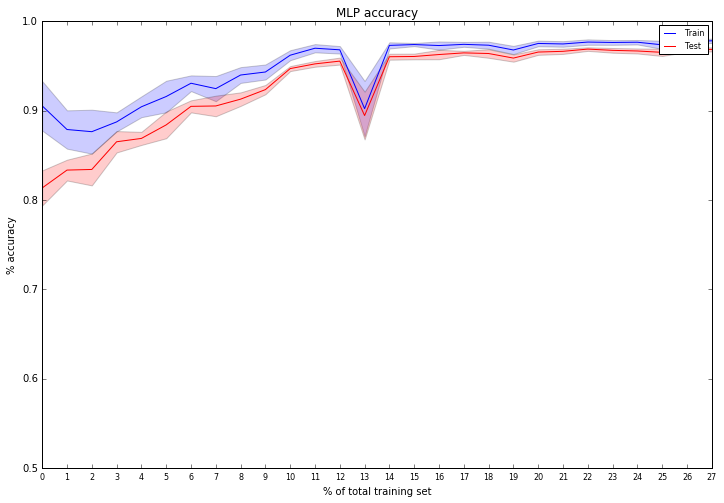

In [23]:
model = "MLP"

acc_train_ = np.asarray( acc_train )
acc_test_ = np.asarray( acc_test )

avgs_train = acc_train_.mean( axis = 1 )
errs_train = acc_train_.std( axis = 1 )

avgs_test = acc_test_.mean( axis = 1 )
errs_test = acc_test_.std( axis = 1 )

avgs = pd.DataFrame( [ avgs_train, avgs_test ] ).transpose()
avgs.columns = [ "Train", "Test" ]

errs = pd.DataFrame( [ errs_train, errs_test ] ).transpose()
errs.columns = [ "Train", "Test" ]

fig, ax = plt.subplots()
fig.set_size_inches( 12, 8, forward = True )
plt.title( model + " accuracy" )
plt.ylim( 0.5, 1.0 )
plt.xlabel( "% of total training set" )
plt.ylabel( "% accuracy" )
avgs.plot.line( ax = ax, color = [ 'b', 'r' ] )
plt.fill_between( avgs.index.values, avgs[ "Train" ] - errs[ "Train" ], avgs[ "Train" ] + errs[ "Train" ], facecolor = 'blue', alpha = 0.2 )
plt.fill_between( avgs.index.values, avgs[ "Test" ] - errs[ "Test" ], avgs[ "Test" ] + errs[ "Test" ], facecolor = 'red', alpha = 0.2 )
plt.xticks( avgs.index.values, map( str, avgs.index.values ), fontsize = 8 )
leg = plt.legend( fontsize = 8 )
plt.show()

### Logistic Regression

In [ ]:
train.head()

In [ ]:
perc = float( 70 )
num_instances = int( math.ceil( ( perc / 100 ) * len( train ) ) )
print num_instances
sub_train = train.sample( num_instances, replace = True )
#sub_train = train
x_train = sub_train[ available_features ]
x_train = normalize( x_train, axis = 0 )
y_train = sub_train[ "class" ]
cx_test = normalize( x_test, axis = 0 )

In [ ]:
x_train[ : 5 ]

In [ ]:
lr = LogisticRegression()
lr.fit( x_train, y_train )
lr_preds = lr.predict( cx_test )
accuracy_score( lr_preds, y_test )

### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit( x_train, y_train )
rf_preds = rf.predict( x_test )
accuracy_score( rf_preds, y_test )

### Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit( x_train, y_train )
nb_preds = nb.predict( x_test )
accuracy_score( nb_preds, y_test )

### Meta

In [ ]:
# code for meta classifier